# 制御コードのロード（最初に一度だけ実行してください）

実験信号の継続時間を変更する場合には再度 qubecalib.meas.SimpleSendRecvProto のインスタンスを生成し直してください．

In [1]:
import qubecalib as qc
from qubecalib import Qube, PortFunc, Lane, PortNo
from e7awgsw import CaptureUnit, CaptureModule, AwgCtrl
import numpy as np

qube = Qube(config_file_name='qube_riken_1-07.yml')
o = qc.meas.SimpleSendRecvProto(
    duration = 1000e-9, # 波形継続時間（目安）
    wait_words = 0, # 1 ワード当たり 4 サンプル (500Msps で 8 ns)
    readin_port = qube[PortFunc.Readin1],
    readout_awg = qube.awg[PortFunc.Readout1]
)
o.repeats = 10

a = qube.awg[PortFunc.Readout1]
w = o.new_sequence(a) # 最初に登録した awg が trigger となります
o.wave_property[a].mhz = 0 # MHz
# o.assign(qube.awg[PortFunc.Readout2], w)

a = qube.awg[PortFunc.Ctrl2][Lane.L0]
w = o.new_sequence(a)
o.wave_property[a].mhz = 0 # MHz


# 周波数変更部分（そのうち改良します）

**LO 周波数を変更すると検波位相が変動してしまうので注意！**

In [21]:
p = PortFunc.Readout1 # ポートの選択
cnco_mhz, awg_mhz = qube[p].set_freq(10000, 9000) # 周波数の設定 (Coarse NCO)
o.wave_property[qube.awg[p]].mhz = awg_mhz # AWG の変調周波数 (-200MHz ~ +200MHz ぐらいが実用範囲？)
qube[p].vatt = 0x800
print('AWG Frequency (Readout1) {} MHz'.format(awg_mhz), flush=True)

p = PortFunc.Ctrl2
nco_mhz, awg_mhz = qube[p].set_freq(10010, 11000)
o.wave_property[qube.awg[p][Lane.L0]].mhz = awg_mhz
qube[p].vatt = 0x800
print('AWG Frequency (Ctrl2) {} MHz'.format(awg_mhz), flush=True)
['{}: {}'.format(k, v.status) for k, v in qube.port.items()]

AWG Frequency (Readout1) 15.625 MHz
AWG Frequency (Ctrl2) 5.625 MHz


['0: RF = 9000.000 MHz LO =  8000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive',
 '1: RF = 9000.000 MHz LO =  8000    MHz IF = 1000.000 MHz ',
 '5: RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '6: RF = 10000.000 MHz LO = 11000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '7: RF = 10015.625 MHz LO = 11000    MHz IF = 984.375 MHz LSB/USB: LSB MODE AWG: Inactive',
 '8: RF = 10000.000 MHz LO = 11000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '12: RF = 10000.000 MHz LO =  9000    MHz IF = 1000.000 MHz ',
 '13: RF = 9984.375 MHz LO =  9000    MHz IF = 984.375 MHz LSB/USB: USB MODE AWG: Inactive']

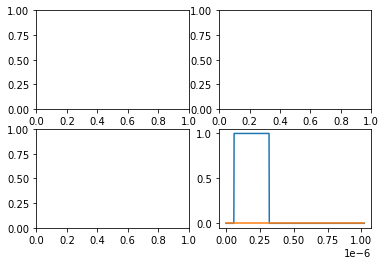

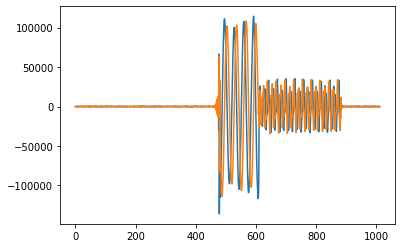

In [26]:
w = o.sequence[qube.awg[PortFunc.Readout1]]
t = w.timeline
w.iq[(60e-9 <= t) & (t < 320e-9)] = 1.0 + 1j * 0.0


w = o.sequence[qube.awg[PortFunc.Ctrl2][Lane.L0]]
t = w.timeline
w.iq[(300e-9 <= t) & (t < 900e-9)] = 1.0 + 1j * 0.0


%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2)

awg = qube.awg[PortFunc.Readout1]
a = np.array(o.sequence[awg].iq)
t = np.array(o.sequence[awg].timeline)
plt.plot(t,np.real(a))
plt.plot(t,np.imag(a))
plt.show()

# a = np.array(w[PortFunc.Readout0].all_samples())
# t = np.arange(0, a.shape[0]) / o._awg_ctrl.SAMPLING_RATE
# plt.plot(t,a[:,0])
# plt.plot(t,a[:,1])
# plt.show()

# a = np.array(w[PortFunc.Readout1].all_samples())
# plt.plot(t,a[:,0])
# plt.plot(t,a[:,1])
# plt.show()

d = o.start()

t = np.arange(0, np.array(d[CaptureUnit.U0]).shape[0]) / AwgCtrl.SAMPLING_RATE
plt.plot(np.array(d[CaptureUnit.U0])[:,0])
plt.plot(np.array(d[CaptureUnit.U0])[:,1])
plt.show()

# plt.plot(np.array(d[CaptureUnit.U4])[:,0])
# plt.plot(np.array(d[CaptureUnit.U4])[:,1])
# plt.show()

In [44]:
2**15

32768

In [4]:
list(o.sequence)

[<AWG.U2: 2>, <AWG.U5: 5>]

In [30]:
w[PortFunc.Readout0].iq

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
      

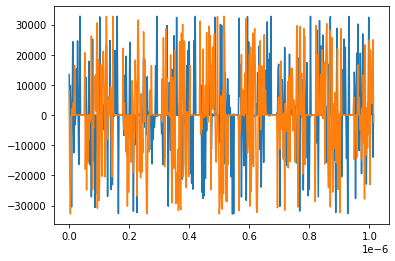

In [22]:
a = np.array(d[CaptureUnit.U4])
plt.plot(t[:a.shape[0]-t.shape[0]],a)

In [13]:
print(qube.ad9082[0].get_jesd_status())
print(qube.ad9082[1].get_jesd_status())

[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]
[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]


In [12]:
[o.do_init(message_out=False) for o in qube.ad9082]

[None, None]

In [15]:
qc.meas.Recv.start(qube.port[PortFunc.Readin1])

{<CaptureUnit.U0: 0>: [(-45.0, 24.0),
  (53.0, -24.0),
  (-17.0, -34.0),
  (-25.0, 38.0),
  (-4.0, -70.0),
  (-37.0, 38.0),
  (40.0, 78.0),
  (6.0, -17.0),
  (21.0, 14.0),
  (10.0, 22.0),
  (-28.0, 49.0),
  (8.0, 62.0),
  (-31.0, -50.0),
  (45.0, -43.0),
  (28.0, -12.0),
  (50.0, 31.0),
  (45.0, 19.0),
  (71.0, -10.0),
  (-56.0, -10.0),
  (-6.0, -29.0),
  (-72.0, 31.0),
  (-31.0, -65.0),
  (72.0, 29.0),
  (-106.0, 77.0),
  (-37.0, -19.0),
  (-23.0, 45.0),
  (58.0, -31.0),
  (-15.0, -14.0),
  (36.0, -44.0),
  (16.0, 1.0),
  (8.0, 5.0),
  (-32.0, -74.0),
  (-13.0, -87.0),
  (-1.0, -15.0),
  (-54.0, 0.0),
  (-40.0, -14.0),
  (-16.0, 32.0),
  (-57.0, -6.0),
  (-8.0, 63.0),
  (48.0, -4.0),
  (-31.0, 102.0),
  (-8.0, 65.0),
  (-14.0, -49.0),
  (51.0, -26.0),
  (41.0, -36.0),
  (34.0, 3.0),
  (1.0, -12.0),
  (3.0, 4.0),
  (-8.0, 32.0),
  (6.0, -68.0),
  (73.0, -64.0),
  (25.0, 24.0),
  (22.0, -57.0),
  (-5.0, 21.0),
  (32.0, 16.0),
  (-46.0, 13.0),
  (-16.0, 17.0),
  (23.0, 20.0),
  (53.0, 35

In [132]:
[v.awg for v in o.wave_sequences.values()]

[<AWG.U15: 15>,
 <AWG.U11: 11>,
 <AWG.U8: 8>,
 <AWG.U5: 5>,
 <AWG.U0: 0>,
 <AWG.U2: 2>]

In [113]:
np.concatenate([t,np.zeros(2)])

array([0.000e+00, 2.000e-09, 4.000e-09, ..., 9.998e-06, 0.000e+00,
       0.000e+00])

In [114]:
t

array([0.000e+00, 2.000e-09, 4.000e-09, ..., 9.994e-06, 9.996e-06,
       9.998e-06])

---

---

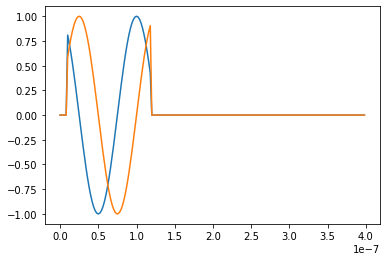

In [103]:
iq = np.zeros(len(t)).astype(complex)
iq[(10e-9 <= t) & (t < 120e-9)] = 1.0 + 1j * 0.0

t0 = 100e-9
freq = 10e+6
phi = 0 / 180 * np.pi
iq2 = iq * np.exp(1j * 2 * np.pi * freq * (t - t0) + phi)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(t[:200],np.real(iq2[:200]))
plt.plot(t[:200],np.imag(iq2[:200]))

# iq2

In [25]:
import subprocess
subprocess.run(["ping",qube.config['ipfpga'],"-c","2", "-W", "300"],stdout=subprocess.PIPE)

CompletedProcess(args=['ping', '10.1.0.25', '-c', '2', '-W', '300'], returncode=0, stdout=b'PING 10.1.0.25 (10.1.0.25) 56(84) bytes of data.\n64 bytes from 10.1.0.25: icmp_seq=1 ttl=64 time=0.083 ms\n64 bytes from 10.1.0.25: icmp_seq=2 ttl=64 time=0.045 ms\n\n--- 10.1.0.25 ping statistics ---\n2 packets transmitted, 2 received, 0% packet loss, time 1024ms\nrtt min/avg/max/mdev = 0.045/0.064/0.083/0.019 ms\n')

In [60]:
period = 1 / CaptureCtrl.SAMPLING_RATE
np.linspace(0,1,CaptureCtrl.SAMPLING_RATE + 1)

array([0.00000000e+00, 2.00000000e-09, 4.00000000e-09, ...,
       9.99999996e-01, 9.99999998e-01, 1.00000000e+00])

In [54]:
CaptureCtrl.SAMPLING_RATE+1

500000001

In [25]:
len(np.zeros(10))

10

In [20]:
import inspect
import e7awgsw
import qubelsi
print(inspect.getsource(qubelsi.ad5328))


import qubelsi.udpsendrecv

class AD5328:

    def __init__(self, addr, path):
        self.handle = qubelsi.udpsendrecv.UDPSendRecv(addr, path)

    def write_values(self, values):
        for i,v in enumerate(value[:8]):
            self.handle.write_ad5328(i, v)
        return values
            
    def write_value(self, addr, value):
        return self.handle.write_ad5328(addr, value)

    def do_init(self, message_out=False):
        self.write_value(0x8, 0x00C) # range 0--3.3V (buffered,Vref)
        self.write_value(0x0, 0x800) # output-A 1.65V
        self.write_value(0x1, 0x800) # output-B 1.65V
        self.write_value(0x2, 0x800) # output-C 1.65V
        self.write_value(0x3, 0x800) # output-D 1.65V
        self.write_value(0x4, 0x800) # output-E 1.65V
        self.write_value(0x5, 0x800) # output-F 1.65V
        self.write_value(0x6, 0x800) # output-G 1.65V
        self.write_value(0x7, 0x800) # output-H 1.65V
        self.write_value(0xA, 0x002) # /LDAC single update(必要